In [ ]:
#!pip install natsort

In [50]:
import mle_logging
import matplotlib.pyplot as plt
import pickle
import os
from natsort import natsorted
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import DataLoader
from torch.optim import lr_scheduler, Adam
# Torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
folder_path = 'test_all_stuff_1/grad_norms/'

final_norm_dict =  {0 : [], 1 : [], 2 : [], 3 : [], 4 : [], 5 : [], 6 : [], 7 : [], 8 : [], 9 : []}

for filename in natsorted(os.listdir(folder_path)):
    epoch_num = int(filename.split('_')[-1].split('.')[0])
    epoch_dict = dict(pickle.load(open(folder_path+filename, 'rb')))
    for key in epoch_dict:
        
        final_norm_dict[key].append(np.mean(epoch_dict[key]))

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches(18.5, 18.5)
for i, (key, values) in enumerate(final_norm_dict.items()):
    ax[i // 2, i % 2].plot(values)
    
    ax[i // 2, i % 2].set_xlabel('Epochs', fontsize=14)
    ax[i // 2, i % 2].set_ylabel('Gradient Norms', fontsize=14)
    
    ax[i // 2, i % 2].set_title('Gradient Norms for class %d' % i, fontsize=14)

fig.tight_layout()
plt.savefig('gradient_norms_cifar10.png')


In [ ]:
folder_path = 'test_all_stuff_1/hessian_eigen/'


final_hessian_eigen =  {0 : [], 1 : [], 2 : [], 3 : [], 4 : [], 5 : [], 6 : [], 7 : [], 8 : [], 9 : []}

for filename in natsorted(os.listdir(folder_path)):
    if filename.endswith('.pkl'):
        epoch_dict = dict(pickle.load(open(folder_path+filename, 'rb')))
        for key in epoch_dict:
            final_hessian_eigen[int(key.split('_')[-1].split('.')[0])].append(epoch_dict[key])

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches(18.5, 18.5)
for i, (key, values) in enumerate(final_hessian_eigen.items()):
    ax[i // 2, i % 2].plot(values)
    
    ax[i // 2, i % 2].set_xlabel('Epochs', fontsize=14)
    ax[i // 2, i % 2].set_ylabel('Max Eigenvalues', fontsize=14)
    
    ax[i // 2, i % 2].set_title('Max Eigenvalues for class %d' % i, fontsize=14)

fig.tight_layout()
plt.savefig('max_eigen_hessian_cifar10.png')

In [ ]:
folder_path = 'test_all_stuff_1/hessian_trace/'


final_hessian_trace =  {0 : [], 1 : [], 2 : [], 3 : [], 4 : [], 5 : [], 6 : [], 7 : [], 8 : [], 9 : []}

for filename in natsorted(os.listdir(folder_path)):
    if filename.endswith('.pkl'):
        epoch_dict = dict(pickle.load(open(folder_path+filename, 'rb')))
        for key in epoch_dict:
            final_hessian_trace[int(key.split('_')[-1].split('.')[0])].append(epoch_dict[key])

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches(18.5, 18.5)
for i, (key, values) in enumerate(final_hessian_trace.items()):
    ax[i // 2, i % 2].plot(values)
    
    ax[i // 2, i % 2].set_xlabel('Epochs', fontsize=14)
    ax[i // 2, i % 2].set_ylabel('Hessian Trace', fontsize=14)
    
    ax[i // 2, i % 2].set_title('Hessian Trace for class %d' % i, fontsize=14)

fig.tight_layout()
plt.savefig('trace_hessian_cifar10.png')

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, use_bn = False):
        super(SimpleCNN, self).__init__()

        self.use_bn = use_bn

        # Conv Layers
        self.cnn_layer1 = nn.Conv2d(3,  16, kernel_size=3, padding=1)
        self.cnn_layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.cnn_layer3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Batch Norm
        if self.use_bn:
            self.bn1 = nn.BatchNorm2d(16)
            self.bn2 = nn.BatchNorm2d(32)
            self.bn3 = nn.BatchNorm2d(32)

        # Pooling
        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Linear layers
        self.linear_layer1 = nn.Linear(32, 32)
        self.linear_layer2 = nn.Linear(32, 10)

    def forward(self, x):

        x = self.cnn_layer1(x)
        if self.use_bn:
            x = self.bn1(x)
        x = self.max_pool(F.relu(x))
        
        x = self.cnn_layer2(x)
        if self.use_bn:
            x = self.bn2(x)
        x = self.max_pool(F.relu(x))

        x = self.cnn_layer3(x)
        if self.use_bn:
            x = self.bn3(x)
        x = self.max_pool(F.relu(x))
        
        x = self.global_avg_pool(x)
        
        x = x.view(-1, 32)
        x = F.relu(self.linear_layer1(x))
        x = self.linear_layer2(x)
        return x    

In [ ]:

checkpoint_dir = 'test_all_stuff_1/models/every_k/'

l2_norms = []

checkpoint_filenames = natsorted(os.listdir(checkpoint_dir))

for curr_filename, prev_filename in zip(checkpoint_filenames, checkpoint_filenames[1:]):
  #print(f'Comparing {curr_filename} and {prev_filename}')
  curr_model = SimpleCNN()
  prev_model = SimpleCNN()
  if prev_filename == checkpoint_filenames[-1]:
    break

  curr_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, curr_filename), map_location='cpu'))
  prev_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, prev_filename), map_location='cpu'))
  
  curr_params = torch.nn.utils.parameters_to_vector(curr_model.parameters())
  prev_params = torch.nn.utils.parameters_to_vector(prev_model.parameters())
  
  l2_norm = torch.norm(curr_params - prev_params, p=2)

  l2_norms.append(l2_norm.detach())

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('L2 Norm')
ax.set_title('Difference in Model parameters w.r.t Epochs (L2 Norm)')
ax.plot(l2_norms)

plt.savefig('model_param_diff.png')

In [57]:
model = SimpleCNN()
model.load_state_dict(torch.load('test_all_stuff_1/models/final/final_seed_1234.pt', map_location='cpu'))

"""classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')"""

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

class_wise_loss =  {0 : 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()

model.eval()
with torch.no_grad():
    for im, labels in test_dataloader:
        outputs = model(im)
        loss = criterion(outputs, labels)
        for i in range(labels.size(0)):
            class_wise_loss[labels[i].item()] += loss.item()

for l in class_wise_loss.keys():
    class_wise_loss[l] /= 1000
        

Files already downloaded and verified


/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'train_accuracy, test_accuracy'}, xlabel='num_epochs', ylabel='train_accuracy, test_accuracy'>)

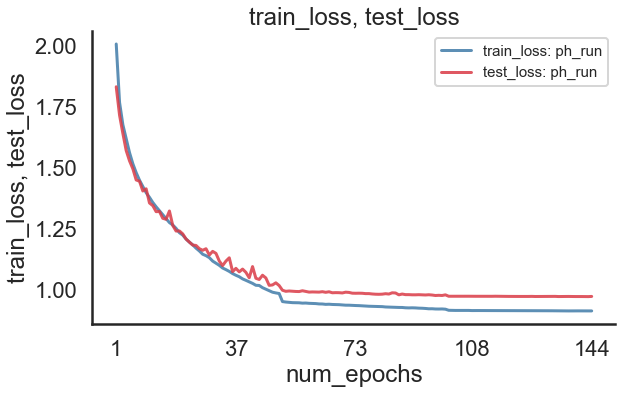

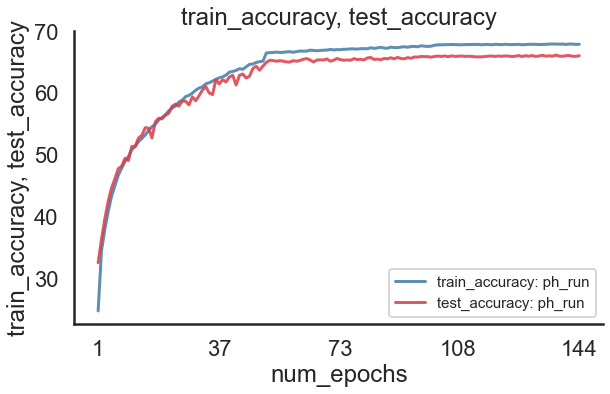

In [62]:
import mle_logging

log = mle_logging.load_log('test_all_stuff_1')

log.plot(['train_loss', 'test_loss'], 'num_epochs')
log.plot(['train_accuracy', 'test_accuracy'], 'num_epochs')